In [1]:
from extract_text import TextExtractor

/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
impressions="right pleural effusion and large pancoast tumor in left lung"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/text_embed"  
file_name='test_k3.npy'
text_extractor = TextExtractor(resume_model="/media/volume/gen-ai-volume/MedSyn/models/test_run2")
text_extractor.run(impressions, output_folder, file_name)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of CXRBertModel were not initialized from the model checkpoint at microsoft/BiomedVLP-CXR-BERT-specialized and are newly initialized: ['classifier.bias

<All keys matched successfully>
(1, 192, 768)
Saved to: /media/volume/gen-ai-volume/MedSyn/results/text_embed/test_k3.npy


In [3]:
from stage1 import run_diffusion_1
import accelerate
accelerate.state.AcceleratorState._shared_state.clear() # dirty hack to reset accelerator state
run_diffusion_1(input_folder="/media/volume/gen-ai-volume/MedSyn/results/text_embed", 
                output_folder= "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard", 
                model_folder="/media/volume/gen-ai-volume/MedSyn/models/stage1", 
                num_sample=1,
                noise_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard/saved_noise/test_k3")

/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:35: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/exouser/miniconda3/envs/medsyn-3-8/lib/python3.8/site-packages/rotary_embedding_torch/rotary_embedding_torch.py:254: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/home/exouser/MedsynBackend/src/stage1.py:1213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only`

loading low-res model...
File already exists: /media/volume/gen-ai-volume/MedSyn/results/img_64_standard/test_k1_sample_0.npy
File already exists: /media/volume/gen-ai-volume/MedSyn/results/img_64_standard/dont_delete_sample_0.npy
File already exists: /media/volume/gen-ai-volume/MedSyn/results/img_64_standard/20250205145212nopleurale_sample_0.npy
Pre-saved noise not found! Generating new fixed noise instead.
Low Resolution: 100%|██████████| 51/51 [00:14<00:00,  3.49it/s]
ATTENTION PATH:  /media/volume/gen-ai-volume/MedSyn/results/img_64_standard/test_k3_sample_0_attention.npy
File already exists: /media/volume/gen-ai-volume/MedSyn/results/img_64_standard/test_k2_sample_0.npy


/home/exouser/MedsynBackend/src/stage1.py:1371: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  flattened_maps = [torch.tensor(m).to("cpu") for maps in all_attention_maps for m in maps]


## Visualizing the saliency map generations

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

generated_filename = "test_k3_sample_0.npy"
output_folder = "/media/volume/gen-ai-volume/MedSyn/results/img_64_standard"
image_path = os.path.join(output_folder, generated_filename)

generated_image = np.load(image_path)  # Shape: (C, D, H, W) or (C, num_slices, height, width)
print(f"Loaded image shape: {generated_image.shape}")  # Check image dimensions

if generated_image.shape[1] == 1:  # Only squeeze axis=1 if it's 1
    generated_image = np.squeeze(generated_image, axis=1)

print(f"Loaded image shape: {generated_image.shape}")  # Check image dimensions


Loaded image shape: (1, 1, 4, 64, 64, 64)
Loaded image shape: (1, 4, 64, 64, 64)


In [2]:
# Define attention map path (modify filename if needed)
attention_map_filename = "test_k3_sample_0_attention.npy"  # Change if necessary
attention_map_path = os.path.join(output_folder, attention_map_filename)

# Load the attention maps
if os.path.exists(attention_map_path):
    attention_maps = np.load(attention_map_path)  # Shape: (num_heads, Slices, Height, Width)
    print(f"Loaded attention map shape: {attention_maps.shape}")
    # Check if dimension 1 is an unnecessary singleton
    if attention_maps.shape[1] == 1:
        attention_maps = attention_maps.squeeze(1)  # Removes singleton dimension

    # Check final shape after squeeze
    print(f"Fixed attention map shape: {attention_maps.shape}")

else:
    print("Attention maps not found! Make sure they were saved.")
    attention_maps = None


Loaded attention map shape: (4, 1, 1280, 64, 8, 8)
Fixed attention map shape: (4, 1280, 64, 8, 8)


In [9]:
def overlay_attention_on_slice(image_slice, attention_slice, alpha=0.5):
    """
    Overlay attention map on a single DICOM slice.
    - image_slice: (H, W) numpy array representing the DICOM slice.
    - attention_slice: (H, W) numpy array representing the attention heatmap.
    - alpha: blending ratio (0 = only image, 1 = only attention).
    """
    # ✅ Ensure `image_slice` is grayscale (H, W)
    if len(image_slice.shape) > 2:  
        image_slice = image_slice[0]  # Take only one slice if multiple channels exist

    # Normalize image slice to [0, 255]
    image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice) + 1e-8)
    image_slice = (image_slice * 255).astype(np.uint8)

    # Normalize attention slice to [0, 255]
    attention_slice = (attention_slice - np.min(attention_slice)) / (np.max(attention_slice) - np.min(attention_slice) + 1e-8)
    attention_slice = (attention_slice * 255).astype(np.uint8)

    # Ensure attention slice is grayscale (single-channel)
    if len(attention_slice.shape) > 2:
        attention_slice = attention_slice.squeeze()

    # ✅ Ensure `attention_slice` is resized to match `image_slice`
    if attention_slice.shape != image_slice.shape:
        attention_slice = cv2.resize(attention_slice, (image_slice.shape[1], image_slice.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Apply colormap (convert grayscale to color)
    heatmap = cv2.applyColorMap(attention_slice, cv2.COLORMAP_JET)

    # ✅ Convert grayscale image to 3-channel (for blending)
    if len(image_slice.shape) == 2:  # Ensure grayscale before converting
        image_slice_colored = cv2.cvtColor(image_slice, cv2.COLOR_GRAY2BGR)
    else:
        raise ValueError(f"image_slice has too many channels: {image_slice.shape}")  # Debugging

    # Blend original image and heatmap
    overlay = cv2.addWeighted(image_slice_colored, 1 - alpha, heatmap, alpha, 0)

    return overlay


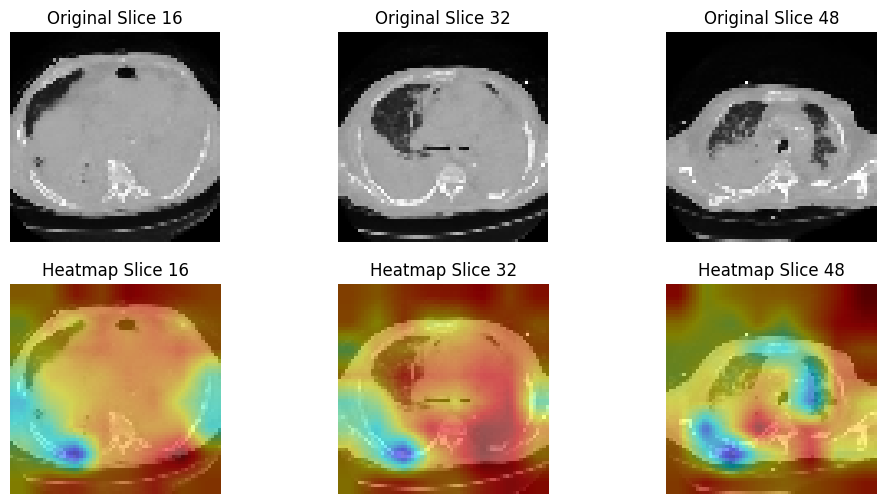

In [12]:
# Select slices for visualization
num_slices = generated_image.shape[2]  # Depth of the image (D)
selected_slices = [num_slices // 4, num_slices // 2, 3 * num_slices // 4]  # Select three slices

plt.figure(figsize=(12, 6))

for i, slice_idx in enumerate(selected_slices):
    original_slice = generated_image[0, :, slice_idx, :, :]  # Extract original image slice
    
    # Ensure grayscale shape (H, W)
    if len(original_slice.shape) > 2:
        original_slice = original_slice[0]  # Take the first channel if multi-channel

    # Extract and process attention slice
    attention_slice = attention_maps[:, 0, slice_idx, :, :].mean(axis=0)  # Average across attention heads
    if len(attention_slice.shape) > 2:
        attention_slice = attention_slice.squeeze()  # Ensure grayscale

    # Overlay attention
    overlay = overlay_attention_on_slice(original_slice, attention_slice)
    # Flip images upside down
    original_slice = np.flipud(original_slice)
    attention_slice = np.flipud(attention_slice)
    overlay = np.flipud(overlay)

    # ✅ Display Original Image & Heatmap Side by Side
    plt.subplot(2, len(selected_slices), i + 1)
    plt.imshow(original_slice, cmap="gray")
    plt.title(f"Original Slice {slice_idx}")
    plt.axis("off")

    plt.subplot(2, len(selected_slices), i + 1 + len(selected_slices))
    plt.imshow(overlay, cmap="gray")
    plt.title(f"Heatmap Slice {slice_idx}")
    plt.axis("off")

plt.show()

In [4]:
from stage2 import run_diffusion_2
import accelerate
accelerate.state.AcceleratorState._shared_state.clear() # dirty hack to reset accelerator state

run_diffusion_2(input_folder="/media/volume/gen-ai-volume/MedSyn/results/img_64_standard", 
                        output_folder="/media/volume/gen-ai-volume/MedSyn/results/img_256_standard", 
                        model_folder="/media/volume/gen-ai-volume/MedSyn/models/stage2",
                        filename="test_k3.npy",
                        num_series_exists=0)

Number of parameters: 54307908
Map Location: cuda
Model path: /media/volume/gen-ai-volume/MedSyn/models/stage2/1000_ckpt/pytorch_model.bin


/home/exouser/MedsynBackend/src/stage2.py:1110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=map_location), s

found 6 videos as gif files at /media/volume/gen-ai-volume/MedSyn/results/img_64_standard
loading model...
Load accelerator state: /media/volume/gen-ai-volume/MedSyn/models/stage2/1000_ckpt
training model...


NotImplementedError: Input Error: Only 3D, 4D and 5D input Tensors supported (got 6D) for the modes: nearest | linear | bilinear | bicubic | trilinear | area | nearest-exact (got nearest)